In [1]:
import numpy as np
np.random.seed(69)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

from surprise.reader import Reader
from surprise import SVD, Dataset, accuracy, SVDpp
from sklearn.decomposition import PCA

import helpers as h

In [2]:
movie_df = pd.read_csv('data/movies_c.txt', delimiter='\t', header=None,
                       names=["Movie Id", "Movie Title", "Unknown", "Action", 
                              "Adventure", "Animation", "Childrens", "Comedy", 
                              "Crime", "Documentary", "Drama", "Fantasy", 
                              "Film-Noir", "Horror", "Musical", "Mystery", 
                              "Romance", "Sci-Fi", "Thriller", "War", 
                              "Western"])

data_df = pd.read_csv('data/data_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
train_df = pd.read_csv('data/train_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
test_df = pd.read_csv('data/test_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])

## Final Training

In [3]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df, reader)
trainset = data.build_full_trainset()

# We just assumed optimal hyperparameters would be the same
# as from our own biased SVD implementation (see 5b for grid search)
algo = SVD(n_factors = 20, n_epochs = 15, reg_all = 1e-3, biased=True)
algo.fit(trainset)
predictions = algo.test(data.construct_testset(data.raw_ratings))
train_err = accuracy.mse(predictions) / 2 # divide by 2 to get comparable error

U = algo.pu
V = algo.qi

data = Dataset.load_from_df(test_df, reader)
testset = data.construct_testset(data.raw_ratings)
predictions = algo.test(testset)
test_err = accuracy.mse(predictions) / 2 # divide by 2 to get comparable error

train_err, test_err

MSE: 0.7450
MSE: 0.8786


(0.37248027476393947, 0.4392775168056285)

In [4]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data_df, reader)
trainset = data.build_full_trainset()

# We just assumed optimal hyperparameters would be the same
# as from our own biased SVD implementation (see 5b for grid search)
algo = SVD(n_factors = 20, n_epochs = 15, reg_all = 1e-3, biased=True)
algo.fit(trainset)

U = algo.pu
V = algo.qi

## Plot things

### Random movies from different genres

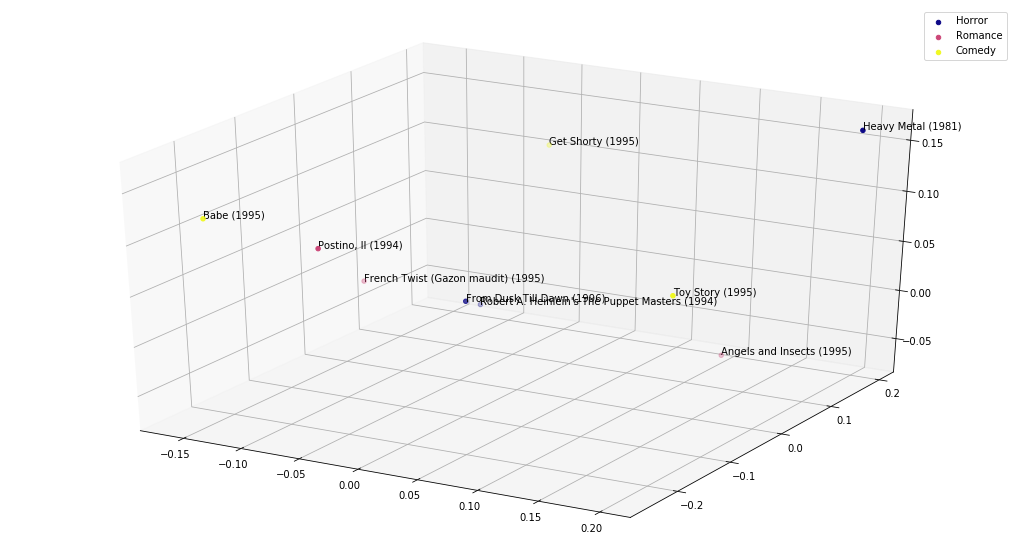

In [5]:
pca = PCA(3)
V_p = pca.fit_transform(V)
U_p = pca.transform(U)

genres = ["Horror", "Romance", "Comedy"]
n_mov = 3
h.plot_w_genre(genres, movie_df, V_p, n_mov=n_mov, dim_3=True)
plt.gcf().set_size_inches(18, 10)

### Popular / best plot

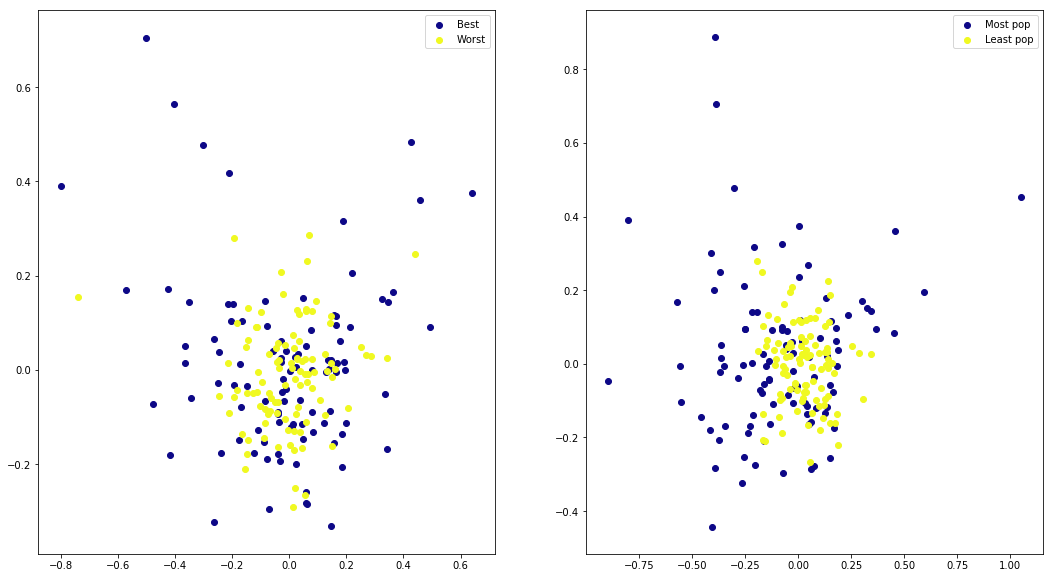

In [6]:
n_mov = 100
fig, ax = plt.subplots(1,2, figsize=(18, 10))
ids1 = [h.best_movs_ids(data_df, n_mov, get_worst=False),\
       h.best_movs_ids(data_df, n_mov, get_worst=True)]
ids2 = [h.pop_movs_ids(data_df, n_mov, get_least_pop=False),\
       h.pop_movs_ids(data_df, n_mov, get_least_pop=True)]
h.plot_w_ids(ids1, movie_df, V_p, labels=["Best", "Worst"], annotate=False, ax=ax[0])
h.plot_w_ids(ids2, movie_df, V_p, labels=["Most pop", "Least pop"], annotate=False, ax=ax[1])

### Genre rep plot

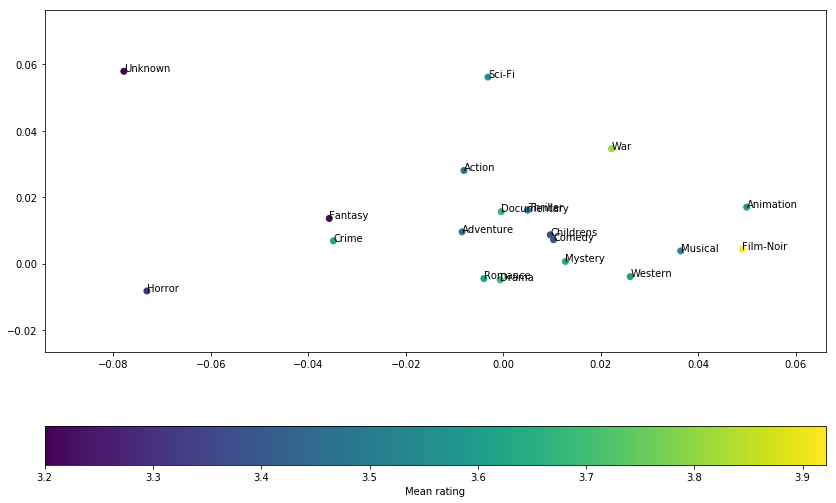

In [7]:
genres, ratings = h.get_genre_mean_ratings(data_df, movie_df)
ratings_dict = {g:r for g,r in zip(genres, ratings)}

genres, reps = h.get_genre_reps(V_p, movie_df)
repres = np.array(reps)
colors = np.array([ratings_dict[g] for g in genres])
sc = plt.scatter(repres[:, 0], repres[:, 1], c=colors)
for g, r in zip(genres, repres):
    plt.annotate(g, r[:2])
clb = plt.colorbar(sc, orientation='horizontal')
clb.set_clim(colors.min(), colors.max())
clb.set_label('Mean rating')
plt.gcf().set_size_inches(14, 9)
plt.savefig('genre_reps0.png')

### 6 plots for spec

In [10]:
plt.gcf().set_size_inches(9, 9);
for i in range(1,7):
    h.six_plots(V_p, data_df, movie_df, which=i);
    plt.savefig(f'5c_{i}.png')
    plt.clf()

<Figure size 648x648 with 0 Axes>